<a href="https://colab.research.google.com/github/Kennedyyegon/conda/blob/main/3_Python_for_WaPOR/N04_Seasonal_Aggregation_and_WP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Using Python libraries for Handling WaPOR Data**

[![](https://raw.githubusercontent.com//wateraccounting/WaPORMOOC/main/images/colab-badge.png)](https://colab.research.google.com/github/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N04_Seasonal_Aggregation_and_WP.ipynb?target="_blank")

#Notebook 4 : Seasonal data aggregation and Water Productivity estimation

In this Notebook we use a script that was developed for the WaPOR project to calculate temporal aggregation of AETI and NPP and seasonal Water Productivity for multiple seasons. Try to understand different parts of the codes using the knowledge you gained in the previous Notebooks.

We will be following these steps:

0. Import Python Libraries
1. Import WaPOR data
2. Define function for temporal aggregation
3. Calculate seasonal AETI and NPP
4. Calculate seasonal WP

**Data needed:**

For the exercises of the [MOOC Python for geospatial analyses using WaPOR data](https://ocw.un-ihe.org/course/view.php?id=272) you can use the following data which **you need to download** using the [Download_WaPORv3_Data Notebook](https://github.com/wateraccounting/WaPORMOOC/blob/main/1_WaPOR_download_colab/Download_WaPORv3_Data.ipynb) before using this notebook. We will be downloading data for three seasons.

1. **Area**: Wad Helal in the Gezira Irrigation Scheme (you can find the \"Wad_Helal.geojson\" file in the data folder of [WaPORMOOC](https://github.com/wateraccounting/WaPORMOOC/tree/main/data))
2. **Type of Data**: AETI and NPP
3. **Spatial resolution**: Level 3
4. **Temporal resolution**: dekadal
5. **Start date**: 2020-10-01 `#Note: this is 2 years more than the previous exercise`
6. **End date**: 2023-04-30

The function `SumSeason` used in this Notebook is based on [WaPORWP](https://github.com/wateraccounting/WAPORWP)
© 2020 Abebe Chukalla. Licensed under CC BY 4.0 Creative Commons.

 © 2024 IHE Delft Licenced under CC BY SA Creative Commons


---

## Step 0. Import modules/libraries

For this Notebook we want to utilise mounting the Colab to be able to keep our results (the previous scripts work with temporary stored files). And to avoid taking a lot of time uploading the data. So the first step is to mount the drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rioxarray --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 64.1 MB/s eta 0:00:00


In [3]:
import os                                 # a module for interacting with the operating system
import sys
import glob                               # used to retrieve files/pathnames matching a specified pattern
import re                                 # re sub() module can be used to replace substring
import rioxarray as rio
import pandas as pd                       # to store and manipulate tabular data in rows of observations and columns of variables
import numpy as np                        # stands for 'Numerical Python, is a python library used for scientific computing with arrays
import calendar
import datetime
from matplotlib import pyplot as plt      # is a plotting library used for 2D graphics in python
from osgeo import gdal

Run Code Cell if you need to upload your .zip file to Google Drive (Cell 1). Run second Code Cell for unzipping your .zip file. Update the paths where the .zip file is located and where you want to store the files. If the files are already there you can skip these two steps.

In [4]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving MIS_whole.geojson to MIS_whole.geojson


In [14]:
!unzip '/content/drive/MyDrive/MIS_2025/data.zip' -d '/content/drive/MyDrive/MIS_2025/'

Archive:  /content/drive/MyDrive/MIS_2025/data.zip
   creating: /content/drive/MyDrive/MIS_2025/content/output/
   creating: /content/drive/MyDrive/MIS_2025/content/output/L3-AETI-D/
  inflating: /content/drive/MyDrive/MIS_2025/content/output/L3-AETI-D/MIS_whole.KMW_L3-AETI-D_NONE_dekad_converted_2024-07-11.tif  
  inflating: /content/drive/MyDrive/MIS_2025/content/output/L3-AETI-D/MIS_whole.KMW_L3-AETI-D_NONE_dekad_converted_2024-11-01.tif  
  inflating: /content/drive/MyDrive/MIS_2025/content/output/L3-AETI-D/MIS_whole.KMW_L3-AETI-D_NONE_dekad_converted_2024-09-21.tif  
  inflating: /content/drive/MyDrive/MIS_2025/content/output/L3-AETI-D/MIS_whole.KMW_L3-AETI-D_NONE_dekad_converted_2024-09-01.tif  
  inflating: /content/drive/MyDrive/MIS_2025/content/output/L3-AETI-D/MIS_whole.KMW_L3-AETI-D_NONE_dekad_converted_2024-10-01.tif  
  inflating: /content/drive/MyDrive/MIS_2025/content/output/L3-AETI-D/MIS_whole.KMW_L3-AETI-D_NONE_dekad_converted_2024-08-01.tif  
  inflating: /content/dri

## Step 1. Import raster (WaPOR) data

In this section you will be importing the WaPOR data you downloaded using [Download_WaPORv3_Data Notebook](https://github.com/wateraccounting/WaPORMOOC/blob/main/1_WaPOR_download_colab/Download_WaPORv3_Data.ipynb). Store the files in a folder called `Python_mooc` in the main folder to execute the script, or adapt the path.

In [15]:
dir_proj = os.path.split(os.getcwd())[0]
dir_data = "/content/drive/MyDrive/MIS_2025/content/output"
input_folderAETI = os.path.join(dir_proj, dir_data, "L3-AETI-D")
input_fhsAETI = glob.glob(os.path.join(input_folderAETI, '*.tif'))

input_folderNPP = os.path.join(dir_proj, dir_data, "L3-NPP-D")
input_fhsNPP = glob.glob(os.path.join(input_folderNPP, '*.tif'))

input_folderT = os.path.join(dir_proj, dir_data, "L3-T-D")
input_fhsT = glob.glob(os.path.join(input_folderT, '*.tif'))

<div class="alert alert-warning">

**NOTE:** Before continuing with the next steps, make sure that you already have the data needed in the folders below.

</div>

In [16]:
print('Folder of input AETI data: '+input_folderAETI)
print('Folder of input NPP data: '+input_folderNPP)
print('Folder of input T data: '+input_folderT)

Folder of input AETI data: /content/drive/MyDrive/MIS_2025/content/output/L3-AETI-D
Folder of input NPP data: /content/drive/MyDrive/MIS_2025/content/output/L3-NPP-D
Folder of input T data: /content/drive/MyDrive/MIS_2025/content/output/L3-T-D


This script also defines the output folder and the start (SOS) and end (EOS) dates for each season:

In [17]:
output_folderAETI = "/content/drive/MyDrive/MIS_2025/OUTPUT/Data/AETI_season"
output_folderNPP = "/content/drive/MyDrive/MIS_2025/OUTPUT/Data/NPP_season"
output_folderT = "/content/drive/MyDrive/MIS_2025/OUTPUT/Data/T_season"

if not os.path.exists(output_folderAETI):
    os.makedirs(output_folderAETI)
output_folderAETI

if not os.path.exists(output_folderNPP):
    os.makedirs(output_folderNPP)
output_folderNPP

'/content/drive/MyDrive/MIS_2025/OUTPUT/Data/NPP_season'

In [18]:
season_periods = {
    'season1': {'SOS': '2024-07-15', 'EOS': '2024-12-31'},
    }

## Step 2. Define function for temporal aggregation

This script defines the function `SumSeason` which is used in the next sections. Using functions in such a way improves the readability and replicability of the scripts and avoids errors. For example we need this function to aggregate AETI and NPP data.

Review this script, main difference compared to the script you used in the previous Notebook is that this script uses the metadata of the files to identify the dates. Disadvantage is that it requires opening and closing of each file and could take time when working with a lot of data. The script also considers part of dekadal values when start or end date is in the middle of the dekad (part of the if-statements).

In [19]:
# summation of raster between two dates
def SumSeason(input_fhs, sowing_date, harvesting_date):

    # add rasters that falls within sowing and harvesting date
    Sums = 0
    for i, in_fh in enumerate(input_fhs):
        # open raster file and get start and end date from attributes
        ds = rio.open_rasterio(in_fh)
        ds = ds.where(ds!=ds.attrs['_FillValue'])
        if i == 0:
          attrs = ds.attrs
        raster_startdate = datetime.datetime.strptime(ds.attrs['start_date'], '%Y-%m-%d' ).date()
        raster_enddate   = datetime.datetime.strptime(ds.attrs['end_date'], '%Y-%m-%d' ).date()

        # accumulate full or part of the dekadal value
        if (raster_startdate >= sowing_date) & (raster_enddate <= harvesting_date):
            Sum = ds
            Sums += Sum
#             print ("1",in_fh)

        elif (raster_startdate <sowing_date)&(raster_enddate >sowing_date)&(raster_enddate <harvesting_date):
            Sum = ds
            Sum = Sum*((raster_enddate-sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("2",in_fh)

        elif (raster_startdate >sowing_date)&(raster_startdate <harvesting_date)&(raster_enddate >harvesting_date):
            Sum = ds
            Sum = Sum*((harvesting_date- raster_startdate)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("3",in_fh)

        elif (sowing_date>=raster_startdate)&(harvesting_date<=raster_enddate):
            Sum = ds
            Sum = Sum*((harvesting_date- sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("4",in_fh)
    attrs.update({'start_date':datetime.datetime.strftime(SOS, '%Y-%m-%d'),
              'end_date': datetime.datetime.strftime(EOS, '%Y-%m-%d'),
              'units' : 'mm/season'})
    del attrs['number_of_days']
    del attrs['temporal_resolution']
    del attrs['units_conversion_factor']

    Sums.attrs  = attrs
    return Sums

## Step 3. Calculate seasonal AETI and NPP

## i) Calculate seasonal Actual Evapotranspiration and Interception (AETI)

In this script the start and end date of each season is read and then the function `SumSeason` is called. Seasonally aggregated data is then saved, and mean and standard deviation (SD) calculated for each season. Final part of the script is plotting all maps.

the mean, SD for  2024-07-15/2024-12-31 = 494.1 & 69.3


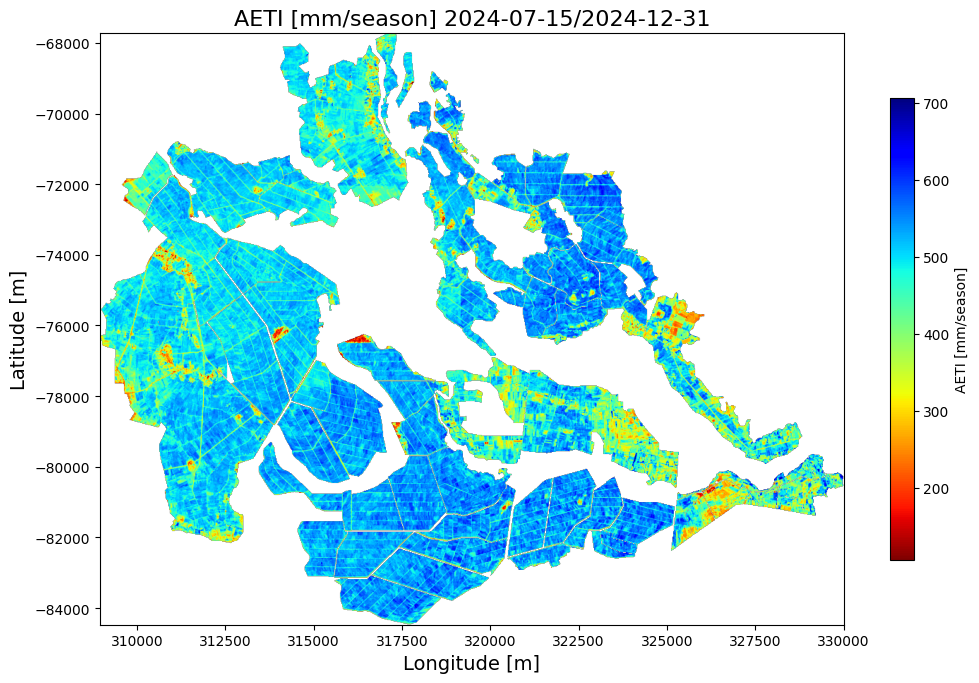

In [20]:
# Assign inputs to the SumSeason function
input_fhs      = input_fhsAETI
output_folder  = output_folderAETI


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'AETI' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='AETI [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('AETI [mm/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ();

## ii) Calculate seasonal Net Primary Production (NPP)

In this Code Cell write the script to create the seasonal NPP maps.

HINT:
    
    Script is very similar to calculating seasonal AETI,
    Dont forget to update the labels of the axis of the maps, check unit of the NPP.

the mean, SD for  2024-07-15/2024-12-31 = 582.6 & 149.6


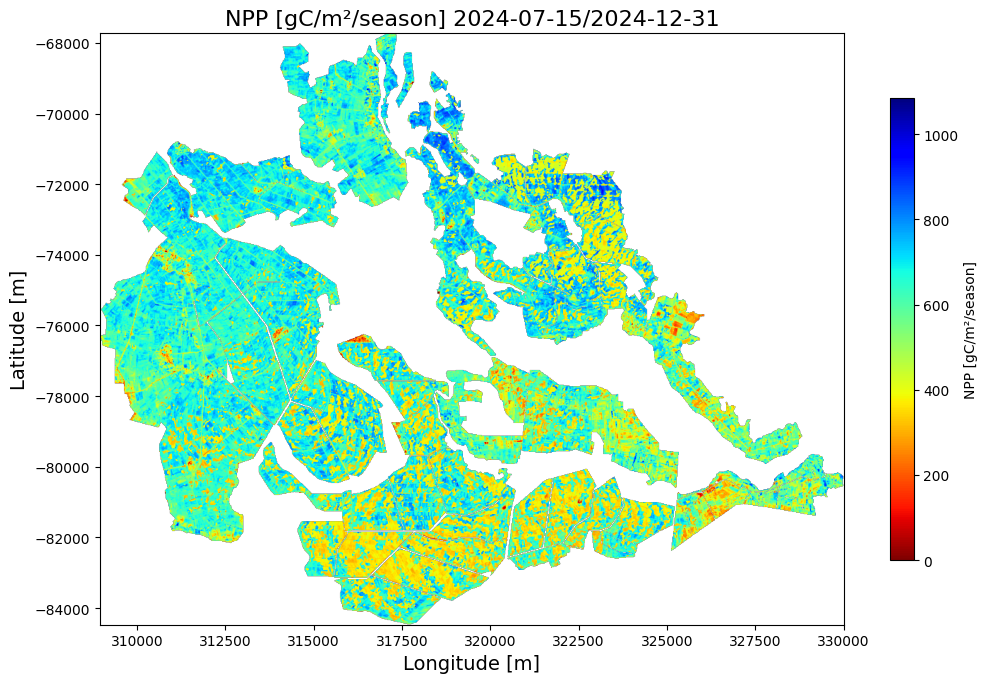

In [22]:
# Assign inputs to the SumSeason function
input_fhs      = input_fhsNPP
output_folder  = output_folderNPP


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'NPP' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='NPP [gC/m²/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('NPP [gC/m²/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ();

In [ ]:
# Assign inputs to the SumSeason function


    # calculate the seasonal value and save in output_folder


    ## save the array in raster format, name it with the raster_id and sowing and harvesting date

    # calculate the mean, SD

    # Plot the raster map




<div class="alert alert-success">

⚡ **EXERCISE 1**:

What are the maximum, mean and standard deviation of the **seasonal AETI and NPP** for season 2 (2021/2022)?

**HINT**: you have to adapt the script to also show the maximum seasonal values and rerun the scripts

Note down the values (rounded to the nearest integer, no decimals), you will need to enter these in the MOOC quiz!
</div>

# Calculating Total Seasonal Biomass Production

Net Primary Production can be used to estimate total biomass production using the following formula:

    TBP = (NPP *22.222)/1000

The value 22.222 is to convert the NPP in gC/m^2 to biomass production in kg/ha. To convert to ton/ha the value is divided by 1000.

Review this script to check what each lines does.

In [24]:
dir_proj = os.path.split(os.getcwd())[0]  # os.getcwd() is for the current directory
dir_data = "/content/drive/MyDrive/MIS_2025/OUTPUT/Data"
input_folderNPPs = os.path.join(dir_proj, dir_data, "NPP_season")
input_fhsNPPs = glob.glob(os.path.join(input_folderNPPs, '*.tif'))

output_folderBM = os.path.join(dir_proj, dir_data, "TBP_season")

# if the directory and folder does not exit, make one
if not os.path.exists(output_folderBM):
    os.makedirs(output_folderBM)
output_folderBM

'/content/drive/MyDrive/MIS_2025/OUTPUT/Data/TBP_season'

In [25]:
glob.glob(os.path.join(input_folderNPPs, '*.tif'))

['/content/drive/MyDrive/MIS_2025/OUTPUT/Data/NPP_season/NPPseason1_2024-07-15_to_2024-12-31.tif']

the mean & SD for  = 12.9 & 3.3


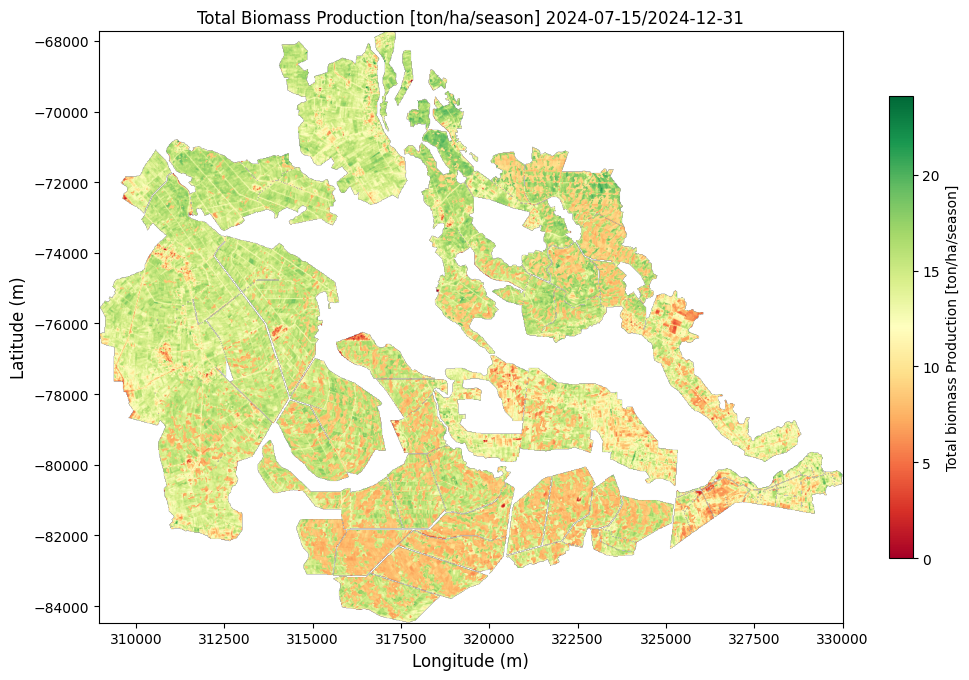

In [26]:

for i, season in enumerate(season_periods):
    NPP  = rio.open_rasterio(input_fhsNPPs[i], nan_values=True)
    TBP = (NPP * 22.222) / 1000  # Total biomass production, 1000 is to convert from kg to ton


    # save into output folder
    output_folder = output_folderBM
    out_fh = os.path.join(output_folder, 'TBP' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    TBP.rio.to_raster(out_fh)

    # Plot the raster map
    seasonal = TBP
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))


    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='Total biomass Production [ton/ha/season]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Total Biomass Production [ton/ha/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'])
    plt.clim()
    plt.show ();

<div class="alert alert-success">

⚡ **EXERCISE 2**:

What is the **maximum** value of the seasonal TBP for season 3 (2022/2023)?

Note down this value (rounded one decimal), you will need to enter these in the MOOC quiz!
</div>

<div class="alert alert-success">

⚡ **EXERCISE 3**: What could be possible reasons for the large range in values in TBP?

1. Farmers are growing different crops
2. Some farmers left their land fallow
3. Not all farmers received sufficient irrigation water
4. Some farms were not weeded timely
5. Some farms were affected by pests
6. All of the above  

Note down your answer, you will need to enter these in the MOOC quiz!
</div>

# Calculating Water Productivity

Finally we will calculate biomass water productivity, which is defined as the total biomass production divided by the AETI:

    WPb = TBP/AETI * 100

The multiplication with 100 is needed to correct the units, first convert TBP in ton/ha to kg/m^2 (divide by 10) and then AETI from mm/season to m/season (divide by 1000) so that the final unit of WPb is kg/m^3

In [27]:
dir_proj = os.path.split(os.getcwd())[0]  # os.getcwd() is for the current directory
dir_data = "/content/drive/MyDrive/MIS_2025/OUTPUT/Data"
input_folder1  = os.path.join(dir_proj, dir_data, "AETI_season")
input_fhsET = glob.glob(os.path.join(input_folder1, '*.tif'))

input_folder2 = os.path.join(dir_proj, dir_data, "TBP_season")
input_fhsTBP  = glob.glob(os.path.join(input_folder2, '*.tif'))


In [28]:
dir_proj = os.path.split(os.getcwd())[0]
dir_data = "Data"

output_folderWPb = os.path.join(dir_proj, dir_data, "WP_season")

# if the directory and folder does not exit, make one
if not os.path.exists(output_folderWPb):
    os.makedirs(output_folderWPb)
output_folderWPb

'/Data/WP_season'

the mean & SD for  = 2.63 & 0.59


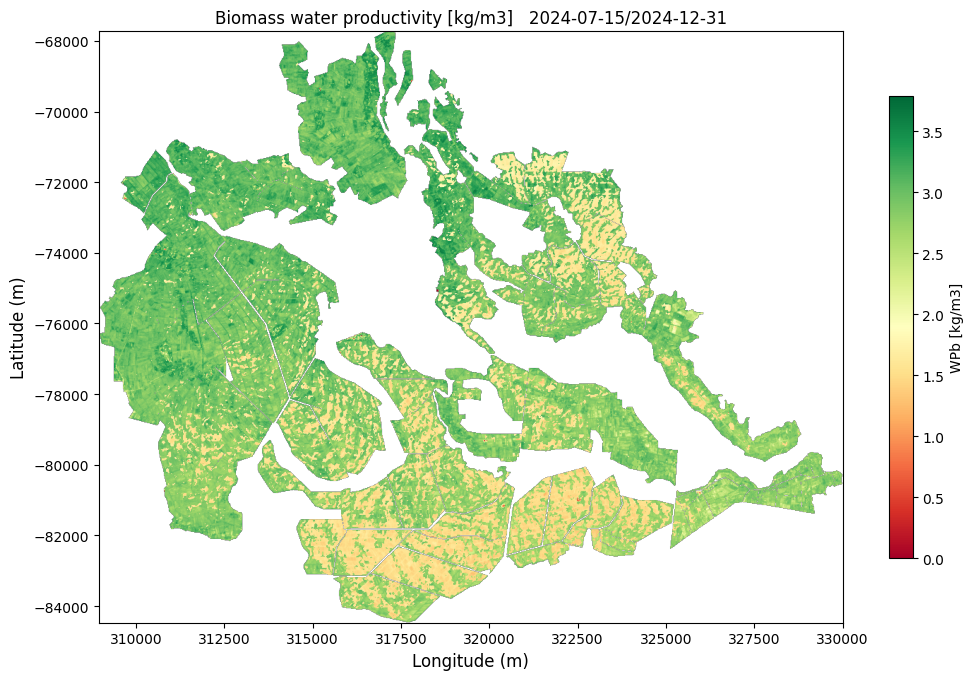

In [29]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsET[0]

## Calculate the WP
for in_fhET, in_fhTBP in zip(input_fhsET, input_fhsTBP):
    AETI = rio.open_rasterio(in_fhET, nan_values=True)
    TBP = rio.open_rasterio(in_fhTBP, nan_values=True)
    WPb  = TBP/AETI*100 # the multiplication with 100 is to correct the units to kg/m3 (from AETI in mm/season and TBP in ton/ha)


    # save into output folder
    output_folder = output_folderWPb
    basename      = os.path.basename(in_fhET).replace('ET', 'WPb')
    output_fn     = os.path.join(output_folder, basename)
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())

    # Plot the raster map
    seasonal = WPb

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(2),'&',np.nanstd(seasonal).round(2))

    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='WPb [kg/m3]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Biomass water productivity [kg/m3]   ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'])
    plt.clim()
    plt.show ()
    ;

<div class="alert alert-success">

⚡ CROP YIELD

Crop parameters for rice


In [36]:
output_folderY = "/content/drive/MyDrive/MIS_2025/OUTPUT/Data/folderY"  # Change this to your actual output directory

The mean & SD for AWPbIseason1_2024-07-15_to_2024-12-31.tif = 7.17 & 1.84


AttributeError: module 'matplotlib.pyplot' has no attribute 't'

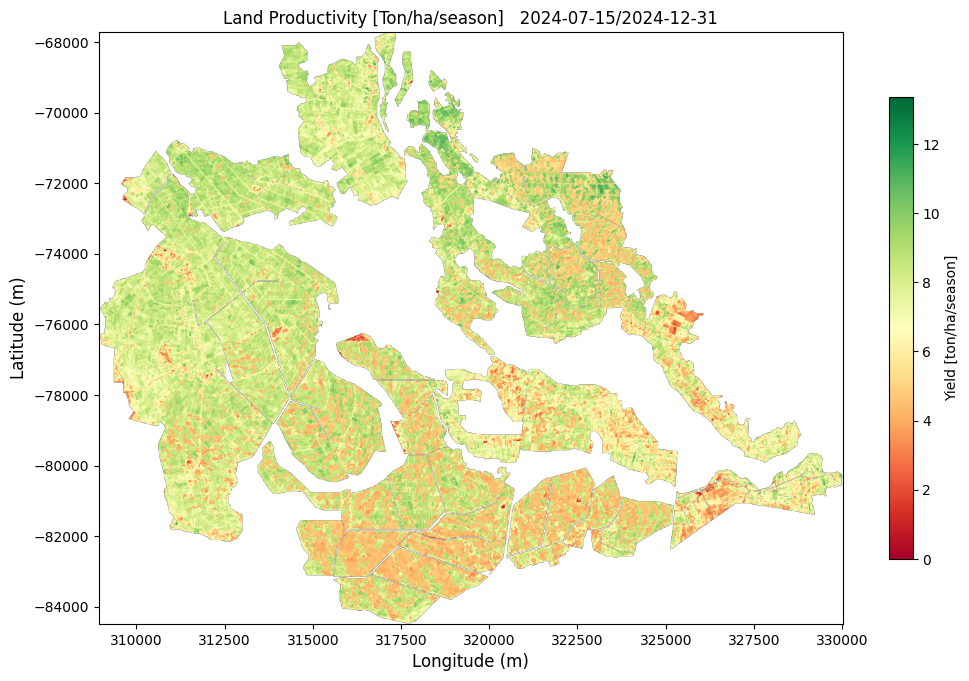

In [39]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Crop-specific parameters
crop_parameters = {
    "MC": 0.15,  # Moisture content (dry matter over fresh biomass)
    "fc": 1.46,  # Light use efficiency correction factor
    "AOT": 0.75,  # Above-ground over total biomass production ratio
    "HI": 0.43  # Harvest Index
}

MC = crop_parameters["MC"]
fc = crop_parameters["fc"]
AOT = crop_parameters["AOT"]
HI = crop_parameters["HI"]

# Ensure MC does not cause division by zero
denominator = 1 - MC
if denominator == 0:
    raise ValueError("MC must not be 1 to avoid division by zero.")

# Loop through input files and process them
for in_fhET, in_fhTBP in zip(input_fhsET, input_fhsTBP):
    with rasterio.open(in_fhET) as aet_src, rasterio.open(in_fhTBP) as tbp_src:
        AETI = aet_src.read(1)  # Read first band
        TBP = tbp_src.read(1)

        # Compute Yield
        Y = HI * AOT * fc * (TBP / denominator)

        # Define output file path
        output_folder = output_folderY
        output_fn = os.path.join(output_folder, basename)

        # Define spatial extent using raster transform
        transform = aet_src.transform
        left, bottom, right, top = transform[2], transform[5] + transform[4] * AETI.shape[0], transform[2] + transform[0] * AETI.shape[1], transform[5]

        # Calculate mean & standard deviation
        mean_Y = np.nanmean(Y).round(2)
        std_Y = np.nanstd(Y).round(2)
        print(f'The mean & SD for {basename} = {mean_Y} & {std_Y}')

        # Plot the raster
        plt.figure(figsize=(12, 8))
        plt.imshow(Y, cmap='RdYlGn', vmin=np.nanmin(Y), vmax=np.nanmax(Y), extent=[left, right, bottom, top])
        plt.colorbar(shrink=0.75, label='Yield [ton/ha/season]')
        plt.title('Land Productivity [Ton/ha/season]   ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'])
        plt.xlabel('Longitude (m)', fontsize=12)
        plt.ylabel('Latitude (m)', fontsize=12)
        plt.t

In [30]:
# Update the crop parameters specific to the crop
MC = 0.15  # moisture content, dry matter over fresh biomass
fc = 1.46  # Light use efficiency correction factor
AOT= 0.75  # above ground over total biomass production ratio(AOT)
HI = 0.43

In [33]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsET[0]

## Calculate the Yield
for in_fhET, in_fhTBP in zip(input_fhsET, input_fhsTBP):
    AETI = rio.open_rasterio(in_fhET, nan_values=True)
    TBP = rio.open_rasterio(in_fhTBP, nan_values=True)
    Y = HI * AOT * fc * (TBP / (1 - MC))


    # save into output folder
    output_folder = output_folderY
    basename      = os.path.basename(in_fhET).replace('ET', 'WPb')
    output_fn     = os.path.join(output_folder, basename)
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())

    # Plot the raster map
    seasonal = Y

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(2),'&',np.nanstd(seasonal).round(2))

    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='Yield [ton/ha/season]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('crop yield [ton/ha/season]   ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'])
    plt.clim()
    plt.show ()
    ;

NameError: name 'output_folderY' is not defined